# How to make a Geometry

##################################
## Rectangular Geometry
##################################

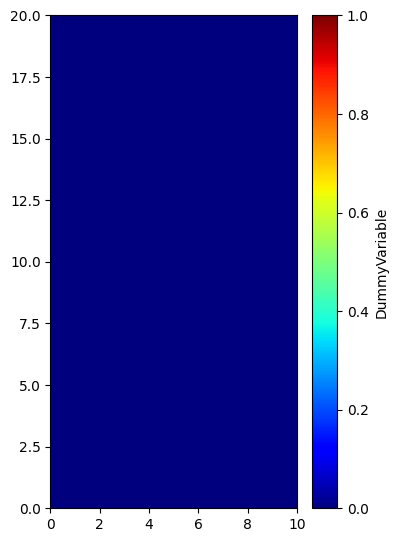

In [ ]:
# 2D Geometry

import numpy as np
import matplotlib.pyplot as plt
from fipy import CellVariable, Grid2D, Viewer, FaceVariable
from fipy.viewers.matplotlibViewer import Matplotlib2DGridViewer

# Define domain parameters
domain_length_x = 10.0
domain_length_y = 20.0
nx, ny = 100, 200
dx = domain_length_x / nx
dy = domain_length_y / ny

# Create a 2D grid mesh
mesh = Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)

# create a dummy variable for visualization
var = CellVariable(name='DummyVariable', mesh=mesh, value=0.0)

viewer = Viewer(vars=var, datamin=0.0, datamax=1.0)
viewer.plotMesh()

# apparently it should show the meshes but for some reason i cannot make it work

##################################
## Circular Geometry
##################################

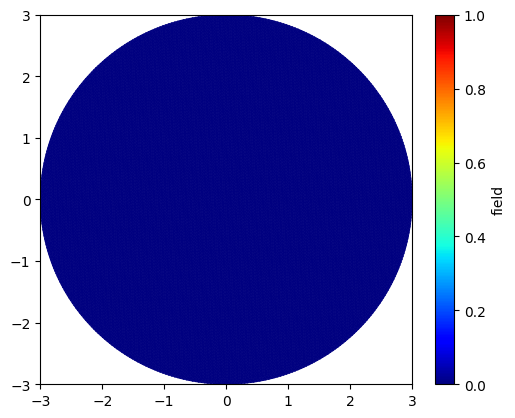

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# FiPy imports
from fipy import CellVariable, Gmsh2D, Viewer

from fipy.tools import numerix

# --- Create a circular mesh using Gmsh2D ---
cellSize = 0.05
radius = 3.0

mesh = Gmsh2D('''
              cellSize = %(cellSize)g;
              radius = %(radius)g;
              Point(1) = {0, 0, 0, cellSize};
              Point(2) = {-radius, 0, 0, cellSize};
              Point(3) = {0, radius, 0, cellSize};
              Point(4) = {radius, 0, 0, cellSize};
              Point(5) = {0, -radius, 0, cellSize};
              Circle(6) = {2, 1, 3};
              Circle(7) = {3, 1, 4};
              Circle(8) = {4, 1, 5};
              Circle(9) = {5, 1, 2};
              Line Loop(10) = {6, 7, 8, 9};
              Plane Surface(11) = {10};
              ''' % locals())

phi = CellVariable(name='field', mesh=mesh, value=0.0)

viewer = Viewer(vars=phi, datamin=0.0, datamax=1.0)
viewer.plotMesh()

##############################################
# Creating Mesh using Gmsh
##############################################

### Another way of creating mesh is to do it via Gmsh. If you have Gmsh installed on your computer, you can open the mesh in gmsh using the following script:

In [6]:
from fipy import Gmsh3D, CellVariable, Viewer
import subprocess

# Load the circle mesh generated by gmsh
mesh = Gmsh3D("Meshing/cylinder.msh")

# Create a dummy variable on the mesh for visualization
var = CellVariable(name="dummy", mesh=mesh, value=0.0)

# Optionally, open the mesh in gmsh GUI
subprocess.Popen(["gmsh", "Meshing/cylinder.msh"])


### I created a folder called Meshing. In this folder you can create a "geometry.geo" file following the gmsh scripting codes and then use the "MeshCreator.py" to create your desired mesh geometry

### We can also select a part of the mesh to visualize using mesio and pyvista packages:

ERROR:root:Unsupported data type: vtktypeint32
2025-02-18 16:41:02.872 (  46.307s) [           54F30]      vtkDataReader.cxx:2025   ERR| vtkUnstructuredGridReader (0x1515a8870): Unsupported data type: vtktypeint32
/opt/anaconda3/envs/old_fipy/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


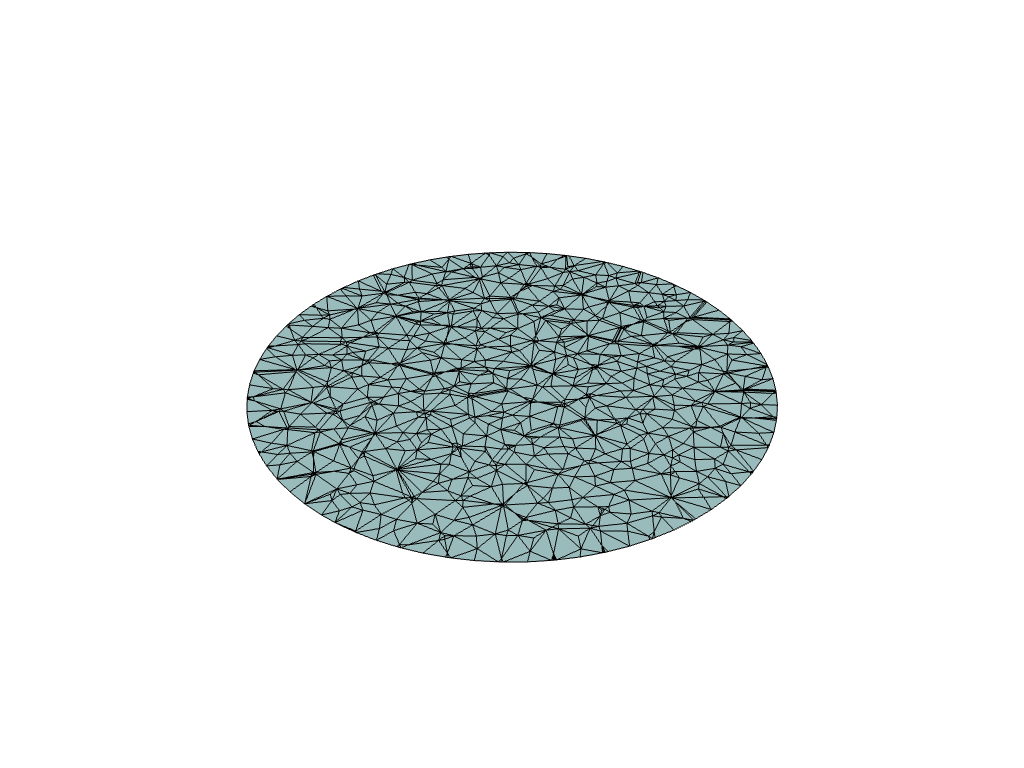

In [2]:
import meshio
mesh = meshio.read("Meshing/cylinder.msh")
meshio.write("cylinder.vtk", mesh)

import pyvista as pv

# Read the VTK mesh
pv_mesh = pv.read("cylinder.vtk")

# Slice the mesh at z=2.5
slc = pv_mesh.slice(normal='z', origin=(0, 0,3))

# Plot the slice
p = pv.Plotter()
p.add_mesh(slc, show_edges=True, color="lightblue")
p.show()


# Explanation of the Diffusion Simulation Code

The code solves a **time-dependent diffusion equation** on a 3D cylindrical domain using FiPy. Below, we explain the physical problem, the mathematics, the boundary conditions, and what the simulation could represent in reality.

---

## 1. The Physical Problem

We are modeling the diffusion of a scalar field \(\phi(x,y,z,t)\) (which could represent, for example, the concentration of a chemical species or the temperature in a material) in a cylindrical domain. 

### Governing Equation

The process is governed by the diffusion equation:
$$
\frac{\partial \phi}{\partial t} = D\, \nabla^2 \phi,
$$

  $$\nabla^2 \phi = \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} + \frac{\partial^2 \phi}{\partial z^2}.
  $$

### Boundary Conditions

- **No-flux (Neumann) conditions** are applied at the boundaries of the cylinder. Mathematically, this means:
  $$
  \frac{\partial \phi}{\partial n} = 0 \quad \text{on the boundary},
  $$
  $$ \text{where} \ \partial \phi/\partial n\ \text{is the derivative normal to the boundary.}$$
  This condition implies that there is no flow of the diffusing quantity into or out of the domain (e.g., an insulated wall). 

---

## 2. The Domain and Mesh

- The domain is a **cylinder**, generated externally using Gmsh and then imported into FiPy via the `Gmsh3D` function.
- The mesh represents the discretization of the cylindrical domain, and FiPy uses it to solve the partial differential equation (PDE) numerically.

---

## 3. Initial Condition

$$ \text{Instead of starting with a uniform field, we initialize} \ \phi \ \text{with a **localized Gaussian bump**:} $$
$$
\phi(x,y,z,0) = \exp\!\left( -\frac{x^2 + y^2 + (z - z_c)^2}{w} \right),
$$
where:
-  Z_c sets the center of the bump along the z -axis 
- w  determines the width of the Gaussian (a smaller value means a sharper, more localized bump).

This initial condition represents a localized region of high concentration (or high temperature) in the center of the cylinder, with the rest of the domain starting at (\phi = 0\).

---

## 4. The Diffusion Process

As time evolves, the high concentration at the center will **diffuse** into the surrounding region. The numerical scheme used is based on the discretized form of the diffusion equation:
$$
\phi^{n+1} = \phi^n + \Delta t \, D\, \nabla^2 \phi^n,
$$
where:
$$  \Delta t = 0.01 \ \text{is the time step}$$
$$ \text{denotes the time step index}$$


A higher diffusion coefficient D = 10.0 is used to accelerate the process so that changes are visible over a short simulated time.

---

## 5. Numerical Implementation and Output

- **Mesh and Variable Initialization:**
  - The mesh is loaded from a Gmsh file.
  - The variable \phi is defined on the mesh and initialized to 0 everywhere.
  - Then, the localized Gaussian bump is imposed on \phi.

- **No-Flux Boundary Conditions:**
  - We do not explicitly impose Dirichlet boundary conditions; instead, we allow the default no-flux (Neumann) conditions to hold on the boundaries. This means the simulation is "closed" with no exchange through the walls of the cylinder.

- **Time-Stepping:**
  - The transient diffusion equation is solved using FiPy's `TransientTerm` for 
  $$\frac{\partial \phi}{\partial t} \ \text{and `DiffusionTerm` for} \ \nabla^2 \phi.$$
  - The solution is updated iteratively in a loop, with each update corresponding to one time step.

- **Output:**
  - After each time step, the current solution \(\phi(x,y,z,t)\) is exported as a VTK file using `VTKCellViewer`. These files (named `output_0000.vtk`, `output_0001.vtk`, etc.) can later be used to create visualizations or movies of the diffusion process.

---

## 6. Physical Interpretation

This simulation could represent, for example, the following real-world scenario:
- **Heat Diffusion:** A localized hot spot in a cylindrical rod (or container) with insulated walls, where heat spreads out over time.
- **Chemical Diffusion:** The release of a chemical substance from a point source inside a cylindrical vessel, where the substance diffuses throughout the vessel.
- **Biological Applications:** The spread of a signaling molecule from a localized source within a cylindrical tissue sample.

In all these cases, the simulation shows how an initially localized disturbance smooths out over time due to diffusion, leading to a more uniform distribution.

---

By visualizing the VTK output files (or creating an animation from them), you can observe the evolution of the diffusion process and better understand the dynamics of the system.


In [ ]:
import os
import numpy as np
from fipy import CellVariable, TransientTerm, DiffusionTerm
from fipy import Gmsh3D
from fipy.viewers.vtkViewer import VTKCellViewer

# Create a folder for outputs
output_folder = "FRAMES"
os.makedirs(output_folder, exist_ok=True)

# Load 3D mesh (ensure this is in MSH v2 format if using FiPy 3.4.5)
mesh = Gmsh3D("Meshing/cylinder.msh")

# Create the variable and initialize to zero everywhere
phi = CellVariable(name="solution", mesh=mesh, value=0.0)

# Instead of imposing boundary constraints, we let the default no-flux (Neumann) conditions hold.
# Set up a localized Gaussian bump in the center of the cylinder:
x, y, z = mesh.cellCenters
# Adjust the center and width as desired:
center_z = 2.5
width = 0.05  # smaller value gives a sharper bump
phi.setValue(np.exp(-((x)**2 + (y)**2 + (z - center_z)**2) / width))

# Increase the diffusion coefficient to accelerate the visible change.
diff_coeff = 10.0

# Time-dependent diffusion equation with increased diffusion:
eq = TransientTerm() == DiffusionTerm(coeff=diff_coeff)

# Choose dt and steps so that the simulation time is short but changes are visible:
dt = 0.01  # smaller time step may be needed with a high diffusion coefficient
steps = 100  # total simulated time = 0.1 (adjust as necessary)

# Create a VTKCellViewer to export the frames
viewer = VTKCellViewer(vars=(phi,))

for step in range(steps):
    eq.sweep(var=phi, dt=dt)
    
    # Construct the filename in the output folder
    filename = os.path.join(output_folder, f"output_{step:04d}.vtk")
    
    # Export the current solution to a VTK file
    viewer.plot(filename=filename)
    
    print(f"Finished step {step}, time = {step * dt:.3f}, file = {filename}")


Finished step 0, time = 0.000, file = FRAMES/output_0000.vtk
Finished step 1, time = 0.010, file = FRAMES/output_0001.vtk
Finished step 2, time = 0.020, file = FRAMES/output_0002.vtk
Finished step 3, time = 0.030, file = FRAMES/output_0003.vtk
Finished step 4, time = 0.040, file = FRAMES/output_0004.vtk
Finished step 5, time = 0.050, file = FRAMES/output_0005.vtk
Finished step 6, time = 0.060, file = FRAMES/output_0006.vtk
Finished step 7, time = 0.070, file = FRAMES/output_0007.vtk
Finished step 8, time = 0.080, file = FRAMES/output_0008.vtk
Finished step 9, time = 0.090, file = FRAMES/output_0009.vtk
Finished step 10, time = 0.100, file = FRAMES/output_0010.vtk
Finished step 11, time = 0.110, file = FRAMES/output_0011.vtk
Finished step 12, time = 0.120, file = FRAMES/output_0012.vtk
Finished step 13, time = 0.130, file = FRAMES/output_0013.vtk
Finished step 14, time = 0.140, file = FRAMES/output_0014.vtk
Finished step 15, time = 0.150, file = FRAMES/output_0015.vtk
Finished step 16, 

In [3]:
import pyvista as pv
import glob
import os

# 1. Collect all your .vtk files in the "FRAMES" folder
vtk_files = sorted(glob.glob("FRAMES/*.vtk"))

# 2. Create a Plotter in off-screen mode to record a movie
plotter = pv.Plotter(off_screen=True)

# 3. Open the .mp4 file
plotter.open_movie("diffusion3D.mp4")

mesh_actor = None

for i, filename in enumerate(vtk_files):
    print(f"Reading {filename}")
    # 4. Read the VTK file into a PyVista mesh
    mesh = pv.read(filename)
    
    # Depending on how FiPy wrote the data, the name might be "solution", "phi", etc.
    # Use mesh.array_names or print(mesh) to see available scalar names
    # Let's assume it's called "phi"
    scalars = mesh["solution"]  # or mesh["solution"] if that’s the name
    
    # 5. On the first file, add the mesh to the scene
    if i == 0:
        # add_mesh returns an actor we can update later
        mesh_actor = plotter.add_mesh(
            mesh,
            scalars=scalars,
            cmap="viridis",
            show_edges=False,
            scalar_bar_args={"title": "solution"},
        )
    else:
        # Update the mesh and scalar range
        mesh_actor.mapper.dataset = mesh
        mesh_actor.mapper.scalar_range = (scalars.min(), scalars.max())

    # 6. Write this frame to the movie
    plotter.write_frame()

    # If you want to rotate the camera or do something each frame, you can do so here, e.g.:
    # plotter.camera.azimuth(5)

# 7. Finalize the movie
plotter.close()

print("Movie saved as diffusion3D.mp4")


Reading FRAMES/output_0000.vtk
Reading FRAMES/output_0001.vtk
Reading FRAMES/output_0002.vtk
Reading FRAMES/output_0003.vtk
Reading FRAMES/output_0004.vtk
Reading FRAMES/output_0005.vtk
Reading FRAMES/output_0006.vtk
Reading FRAMES/output_0007.vtk
Reading FRAMES/output_0008.vtk
Reading FRAMES/output_0009.vtk
Reading FRAMES/output_0010.vtk
Reading FRAMES/output_0011.vtk
Reading FRAMES/output_0012.vtk
Reading FRAMES/output_0013.vtk
Reading FRAMES/output_0014.vtk
Reading FRAMES/output_0015.vtk
Reading FRAMES/output_0016.vtk
Reading FRAMES/output_0017.vtk
Reading FRAMES/output_0018.vtk
Reading FRAMES/output_0019.vtk
Reading FRAMES/output_0020.vtk
Reading FRAMES/output_0021.vtk
Reading FRAMES/output_0022.vtk
Reading FRAMES/output_0023.vtk
Reading FRAMES/output_0024.vtk
Reading FRAMES/output_0025.vtk
Reading FRAMES/output_0026.vtk
Reading FRAMES/output_0027.vtk
Reading FRAMES/output_0028.vtk
Reading FRAMES/output_0029.vtk
Reading FRAMES/output_0030.vtk
Reading FRAMES/output_0031.vtk
Reading 

In [12]:
mesh = pv.read("FRAMES/output_0000.vtk")
print("Array names:", mesh.array_names)

Array names: ['solution']


In [5]:
import pyvista as pv
import glob
import os

# Collect all VTK files from the FRAMES folder
vtk_files = sorted(glob.glob(os.path.join("FRAMES", "*.vtk")))

# Create a PyVista Plotter in off-screen mode to record a movie
plotter = pv.Plotter(off_screen=True)
# Open the movie file (you can adjust fps and quality as needed)
plotter.open_movie("cross_section_diffusion.mp4", framerate=10, quality=5)

# Define the slice parameters (adjust origin as needed)
slice_normal = 'z'
slice_origin = (0, 0, 3.5)  # slice plane at z=2.5

# Loop over each VTK file (each representing one time step)
for i, filename in enumerate(vtk_files):
    print(f"Processing frame: {filename}")
    # Read the full 3D mesh
    mesh = pv.read(filename)
    
    # Create a slice through the mesh
    slice_mesh = mesh.slice(normal=slice_normal, origin=slice_origin)
    
    # Clear previous actors
    plotter.clear()
    
    # IMPORTANT: Determine the correct scalar array name. If you’re not sure, you can print it:
    # print("Available scalar arrays:", slice_mesh.array_names)
    # Assume here the scalar name is "phi" (change as needed)
    if "phi" in slice_mesh.array_names:
        scalars = "phi"
    else:
        # Fallback: pick the first available cell array
        scalars = slice_mesh.array_names[0]
    
    # Add the slice to the plotter, with appropriate color mapping
    plotter.add_mesh(slice_mesh, scalars=scalars, cmap="viridis", 
                     show_edges=True, scalar_bar_args={"title": scalars})
    
    # Optionally adjust the camera if desired (e.g., zoom or rotate)
    plotter.camera_position = 'xy'
    
    # Write the current frame to the movie
    plotter.write_frame()

# Finalize and close the movie file
plotter.close()

print("Movie saved as cross_section_diffusion.mp4")


Processing frame: FRAMES/output_0000.vtk
Processing frame: FRAMES/output_0001.vtk
Processing frame: FRAMES/output_0002.vtk
Processing frame: FRAMES/output_0003.vtk
Processing frame: FRAMES/output_0004.vtk
Processing frame: FRAMES/output_0005.vtk
Processing frame: FRAMES/output_0006.vtk
Processing frame: FRAMES/output_0007.vtk
Processing frame: FRAMES/output_0008.vtk
Processing frame: FRAMES/output_0009.vtk
Processing frame: FRAMES/output_0010.vtk
Processing frame: FRAMES/output_0011.vtk
Processing frame: FRAMES/output_0012.vtk
Processing frame: FRAMES/output_0013.vtk
Processing frame: FRAMES/output_0014.vtk
Processing frame: FRAMES/output_0015.vtk
Processing frame: FRAMES/output_0016.vtk
Processing frame: FRAMES/output_0017.vtk
Processing frame: FRAMES/output_0018.vtk
Processing frame: FRAMES/output_0019.vtk
Processing frame: FRAMES/output_0020.vtk
Processing frame: FRAMES/output_0021.vtk
Processing frame: FRAMES/output_0022.vtk
Processing frame: FRAMES/output_0023.vtk
Processing frame